In [1]:
import tensorflow as tf
import numpy as np
import edward as ed
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns
from edward.models import Categorical, Dirichlet, InverseGamma, Normal, MultivariateNormalDiag, Mixture, Empirical, ParamMixture
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano
import pymc3 as pm
import theano.tensor as tt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
import warnings
warnings.filterwarnings('ignore')

env: THEANO_FLAGS=device=cpu,floatX=float32


In [2]:
import sys
import os
codebase = '../'
sys.path.append(codebase)
from src.utils import get_segment_img, predict_cluster, plot_seg_vs_truth, cluster_metric, PDI, plot_pdi_wapdi

# Gaussian mixture model for image segmentation task

## Introduction

Image segmentation is a widely-used technique in computer vision. It enables us to extract useful information from an image by dividing it into several regions. In this notebook, we focus on color-based clustering to perform segmentation. We go through [[Box's Loop](https://www.jstor.org/stable/2286841?seq=1#metadata_info_tab_contents)] by first building Gaussian mixture model (GMM), then making inference with MCMC and ADVI [[advi2016](https://arxiv.org/pdf/1603.00788.pdf)] and finally evaluating our segmentation result through Bayesian criticism and task-specific criteria.  

## Dataset

Our data comes from [the BSD500](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/), which contains both images and hand-labeled segmentations.

First, let's look at the example image.

image shape: (321, 481, 3)


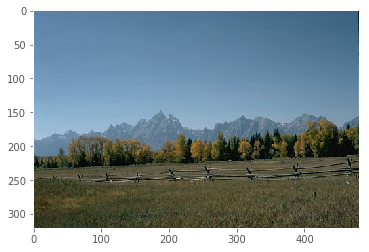

In [88]:
train_path = "../BSR/BSDS500/data/images/train/"
img_no = 2092
img = plt.imread(train_path+"{0:d}.jpg".format(img_no))
plt.imshow(img)
print("image shape:", img.shape)

In [4]:
X = img.reshape(-1, 3).astype(int)
N, D = X.shape
print("flatten pixel matrix shape:", X.shape)

flatten pixel matrix shape: (154401, 3)


## Model

We use a GMM to perform image segmentation:

$$p(\pi) = \text{Dirichlet} (\pi | \alpha \mathbf{1}_k)$$

For each cluster $k \in 1:K$:

$$p(\mu_k) = \text{Normal}(\alpha_k,\beta_k)$$

$$p(\sigma^2_k ) = \text{InverseGamma} (a,b) $$

For each data point $x_n$:

$$p(x_n | \pi, \mu, \sigma) = \sum_{i=1}^K \pi_k \text{Normal}(x_n | \mu_k, \sigma^2_k)$$

In this task, we treat each pixel as $x_n$, where a pixel is a 3-D vector of RGB color value ranging from 0 to 255.

To fully specify the model, we need to choose the cluster number and the prior parameter. In the following experiments, we set $\alpha=a=b=1$, and __we will mainly focus on tuning the prior of the cluster center $\mu_k$__.

### 1. Setting the number of clusters $K$

First, we need to specify the number of clusters $K$. A common way to pre-select $K$ is by observing the color histogram.

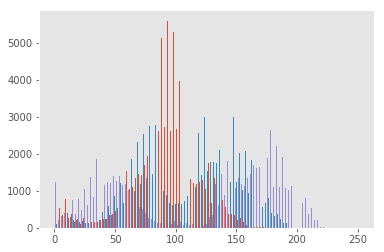

In [5]:
plt.hist(X, bins=200);

Note that the histograms of 3 RGB channels are independent, while what we want is to cluster pixels based on a combination of 3 channels. Hence it only roughly gives us a sense of how many clusters there should be.

It seems like there are 9 clusters in the color histogram. So we make:

In [6]:
K = 9

### 2. Setting the prior

Initializing mixture models is always a challenge. For the prior of cluster center $\mu_k$, we hope that it could spread over the RGB value space -- [0,255]. 

First, we try a shared prior for all cluster centers, that is for all $k$, $$\mu_k \sim \text{Normal}(127, 80^2)$$.

In [7]:
# Edward Model
with tf.name_scope("model"):
    pi_ed = Dirichlet(concentration=tf.constant([1.0] * K, name="pi/weights"), name= "pi")
    mu_ed = Normal(loc= tf.ones(D, name="centroids/loc") * 127, 
                scale= tf.ones(D, name="centroids/scale") * 80, sample_shape=K, name= "centroids")
    sigmasq_ed = InverseGamma(concentration=tf.ones(D, name="variability/concentration"), 
                         rate=tf.ones(D, name="variability/rate"), sample_shape=K, name= "variability")
    x_ed = ParamMixture(pi_ed, {'loc': mu_ed, 'scale_diag': tf.sqrt(sigmasq_ed)},
                     MultivariateNormalDiag, sample_shape=N, name= "mixture")
    z_ed = x_ed.cat

In [33]:
# Pymc model
X_shared = theano.shared(X)
minibatch_size = 500
X_minibatch = pm.Minibatch(X, minibatch_size)
np.random.seed(45)
with pm.Model() as model:
    pi = pm.Dirichlet('pi', np.ones(K))
    comp_dist = []
    mu = []
    sigma_sq = []
    cov = []
    for i in range(K):
        mu.append(pm.Normal('mu%i' % i, 127, 80, shape=D))
        sigma_sq.append(pm.InverseGamma('sigma_sq%i' % i, 1, 1, shape=D))
        cov.append(tt.nlinalg.alloc_diag(sigma_sq[i]))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], cov=cov[i]))
    xobs = pm.Mixture('x_obs', pi, comp_dist,
            observed=X_shared)

## Inference

Now, we make inference via MCMC (Gibbs sampling) and ADVI.

### MCMC

In [9]:
T = 1000  # number of samples
with tf.name_scope("posterior"):
    qpi = Empirical(tf.get_variable("qpi/params", [T, K],initializer=tf.constant_initializer(1.0/K)))
    qmu = Empirical(tf.get_variable("qmu/params", [T, K, D],initializer=tf.zeros_initializer()))
    qsigma = Empirical(tf.get_variable("qsigma/params", [T, K, D],initializer=tf.ones_initializer()))
    qz = Empirical(tf.get_variable("qz/params", [T, N],initializer=tf.zeros_initializer(),dtype=tf.int32))

In [10]:
%%time
inference = ed.Gibbs({pi_ed: qpi, mu_ed: qmu, sigmasq_ed: qsigma, z_ed: qz},data={x_ed: X})
inference.initialize(n_print=500, logdir='log/IMG={}_K={}_T={}'.format(img_no, K, T))
sess = ed.get_session()
tf.global_variables_initializer().run()
for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
inference.finalize()

1000/1000 [100%] ██████████████████████████████ Elapsed: 3955s | Acceptance Rate: 1.000
CPU times: user 4h 7min 35s, sys: 1min 31s, total: 4h 9min 7s
Wall time: 1h 5min 58s


In [11]:
%%time
M = 300 # posterior samples
mu_sample, sigmasq_sample, pi_sample = qmu.sample(M), qsigma.sample(M), qpi.sample(M)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample, scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.cast(tf.tile(tf.reshape(X, [N, 1, 1, D]), [1, M, K, 1]), dtype=tf.float32)
log_liks = tf.reduce_mean(tf.reduce_sum(x_post.log_prob(x_broadcasted), 3), 1)
clusters = tf.argmax(log_liks, 1).eval()
posterior_mu = qmu.params.eval().mean(axis=0)

CPU times: user 7min 49s, sys: 2min 42s, total: 10min 31s
Wall time: 4min 20s


### ADVI

Average Loss = 1.1471e+06: 100%|██████████| 10000/10000 [01:22<00:00, 121.45it/s]
Finished [100%]: Average Loss = 1.146e+06


CPU times: user 1min 29s, sys: 10.7 s, total: 1min 40s
Wall time: 1min 33s


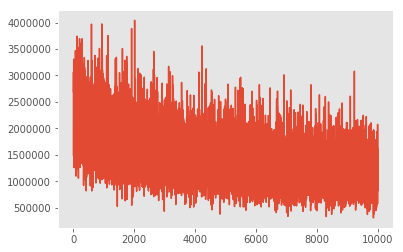

In [34]:
with model:
    advi = pm.ADVI()
    %time advi.fit(10000, more_replacements={X_shared: X_minibatch},obj_optimizer= pm.adagrad(learning_rate=1e-2))
plt.plot(advi.hist);

The loss (=-ELBO) curve is noisy, but in general, decreasing.

## Criticism: 

### 1. Segmentation results

The segmented image is the most straightforward approach to evaluate the inference results, which is obtained as follows:
- assign each pixel to the most probable cluster
- set the RGB value of the pixel to the RGB value of its assigned cluster center.

In [13]:
img_mcmc = get_segment_img(clusters, img, posterior_mu, mcmc=True)

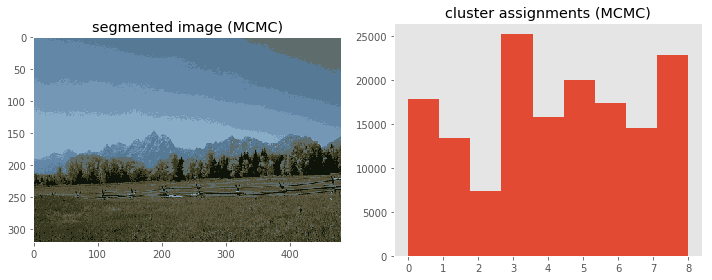

In [14]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].imshow(img_mcmc)
axs[0].set_title("segmented image (MCMC)")
axs[1].hist(clusters, bins=K);
axs[1].set_title("cluster assignments (MCMC)")
plt.tight_layout()

For MCMC, both the segmentation result and the inferred RGB value are good.

In [35]:
y, point = predict_cluster(advi.approx, 1000, X, model, K, cov="cov_diagonal")
img_advi = get_segment_img(y,img, point)

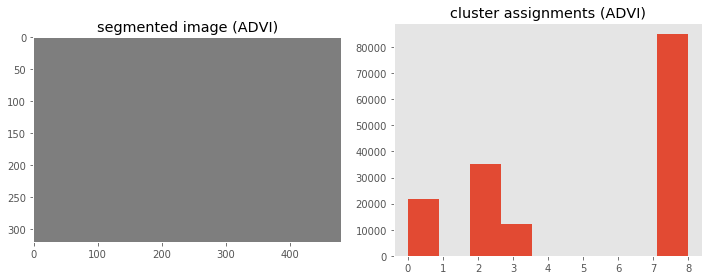

In [36]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].imshow(img_advi)
axs[0].set_title("segmented image (ADVI)")
axs[1].hist(y, bins=K);
axs[1].set_title("cluster assignments (ADVI)")
plt.tight_layout()

ADVI's segmentation result is bad with only four clusters are assigned. Moreover, the RGB values of all identified cluster centers are almost identical.

#### Why ADVI fails?

Is this bad result due to ADVI, or the model prior setting? We diagnose this by plotting the posterior distribution.

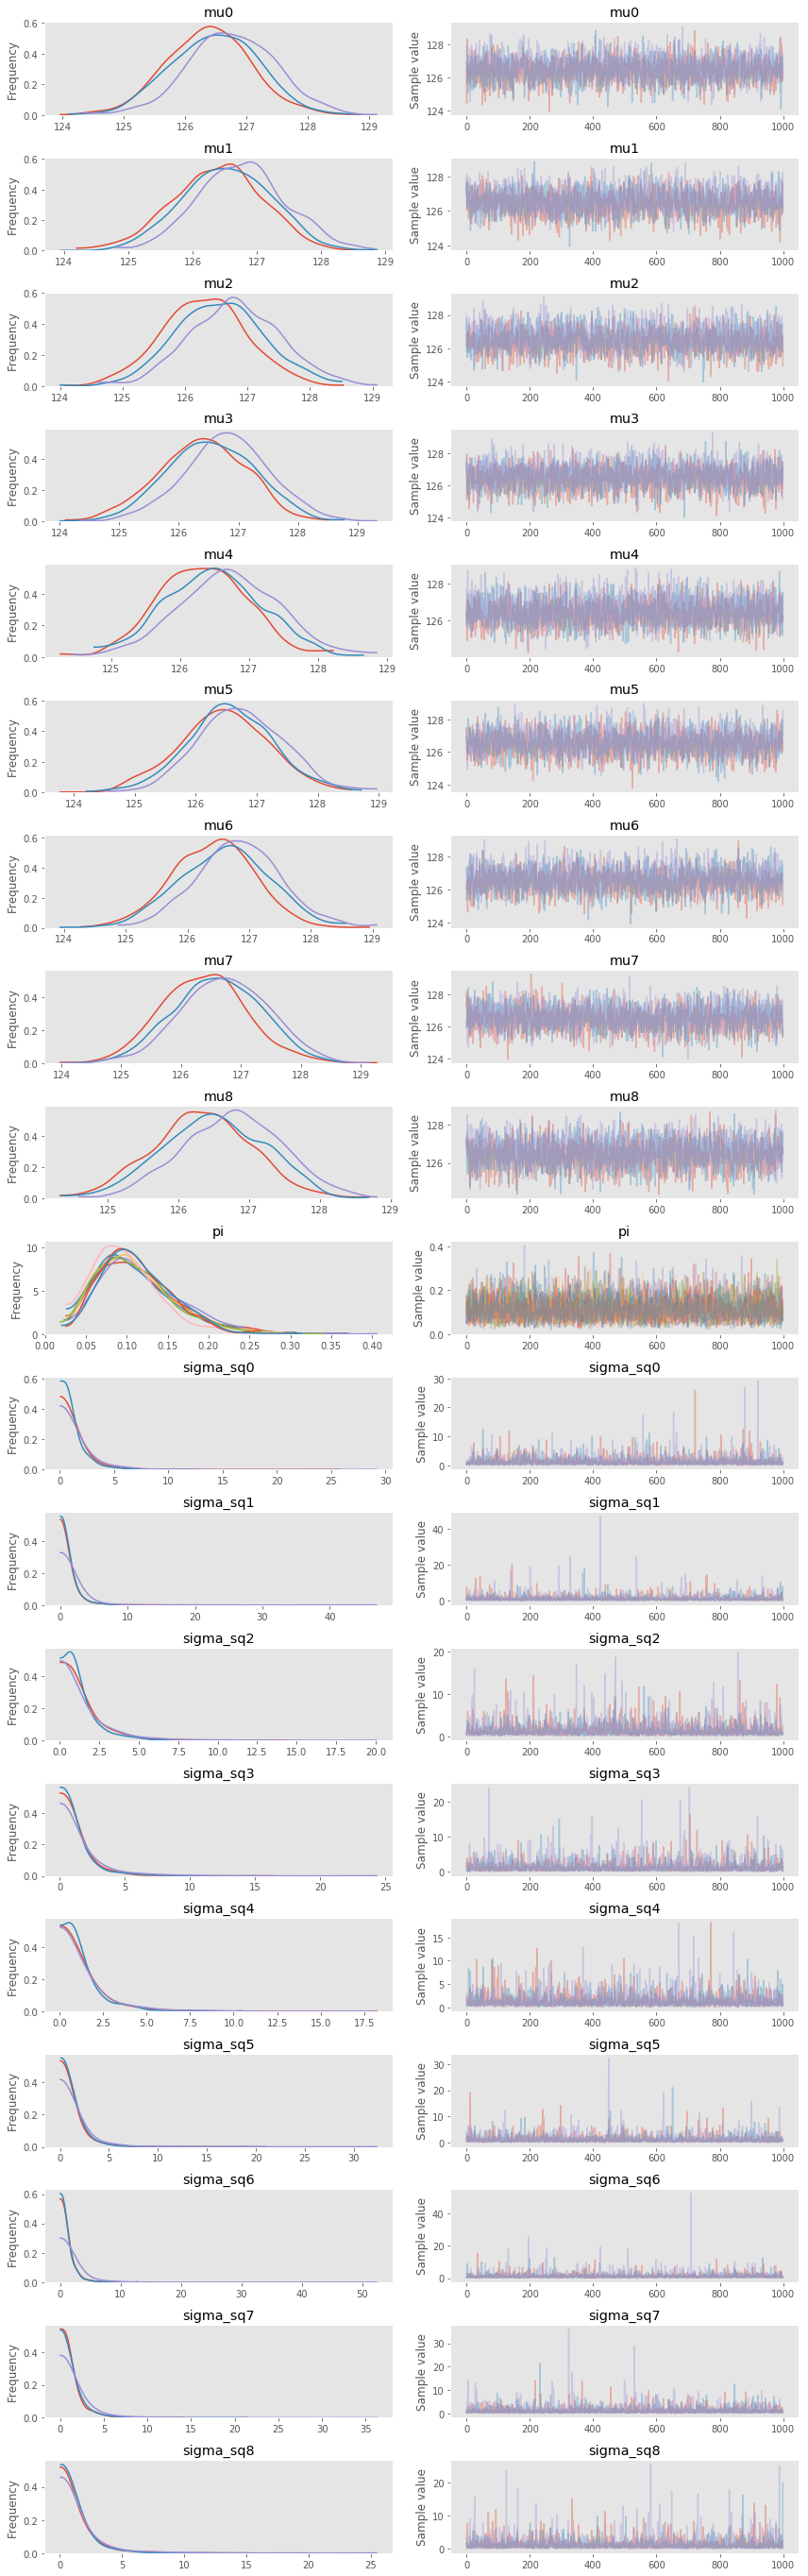

In [37]:
post_samples = advi.approx.sample(1000)
pm.traceplot(post_samples);

As shown above, the posterior distributions of the cluster centers, $\mu_k$, collapse to one distribution which is centered around the prior mean -- 127.

One possible reason is that ADVI is sensitive to the shared prior setting, hence the optimization process is stuck at a local optimum, leading to the "distribution collapse". 

#### Solution
To fix this issue for ADVI, we try a different prior setting of $\mu_k$: 

$$\mu_k \sim \text{Normal}(\alpha_k, \beta_k),$$

where $\alpha_{k}$ is randomly picked from 20-230, and $\beta_k$ is set to $20$ for all $k$. 

The intuition is that we hope that all $\mu_k$s could spread over the RGB space and avoid overlapping with each other.

## Reset model

In [38]:
# Pymc model
cluster_means = []
np.random.seed(45)
with pm.Model() as model:
    pi = pm.Dirichlet('pi', np.ones(K))
    comp_dist = []
    mu = []
    sigma_sq = []
    cov = []
    for i in range(K):
        temp_mean = np.random.randint(low=20, high=230, size=D)
        mu.append(pm.Normal('mu%i' % i, temp_mean, 20, shape=D))
        sigma_sq.append(pm.InverseGamma('sigma_sq%i' % i, 1, 1, shape=D))
        cov.append(tt.nlinalg.alloc_diag(sigma_sq[i]))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], cov=cov[i]))      
        cluster_means.append(temp_mean)
    xobs = pm.Mixture('x_obs', pi, comp_dist,
                      observed=X_shared)

In [39]:
# Edward model
cluster_means_tf = tf.convert_to_tensor(np.asarray(cluster_means), dtype=tf.float32)
with tf.name_scope("model_ed2"):
    pi_ed2 = Dirichlet(concentration=tf.constant([1.0] * K, name="pi/weights"), name= "pi")
    mu_ed2 = Normal(loc= cluster_means_tf, scale= tf.ones(D, name="centroids/scale")*20, name= "centroids")
    sigmasq_ed2 = InverseGamma(concentration=tf.ones(D, name="variability/concentration"), 
                         rate=tf.ones(D, name="variability/rate"), sample_shape=K, name= "variability")
    x_ed2 = ParamMixture(pi_ed2, {'loc': mu_ed2, 'scale_diag': tf.sqrt(sigmasq_ed2)},
                     MultivariateNormalDiag, sample_shape=N, name= "mixture")
    z_ed2 = x_ed2.cat

## Inference
### MCMC

In [40]:
T = 1000  # number of MCMC samples
with tf.name_scope("posterior_2"):
    qpi_2 = Empirical(tf.get_variable("qpi_2/params", [T, K], initializer=tf.constant_initializer(1.0/K)))
    qmu_2 = Empirical(tf.get_variable("qmu_2/params", [T, K, D], initializer=tf.zeros_initializer()))
    qsigma_2 = Empirical(tf.get_variable("qsigma_2/params", [T, K, D], initializer=tf.ones_initializer()))
    qz_2 = Empirical(tf.get_variable("qz_2/params", [T, N], initializer=tf.zeros_initializer(), dtype=tf.int32))

In [41]:
%%time
inference_2 = ed.Gibbs({pi_ed2: qpi_2, mu_ed2: qmu_2, sigmasq_ed2: qsigma_2, z_ed2: qz_2}, data={x_ed2: X})
inference_2.initialize(n_print=500, logdir='log/IMG={}_K={}_T={}_model2'.format(img_no, K, T))
sess = ed.get_session()
tf.global_variables_initializer().run()
for _ in range(inference_2.n_iter):
    info_dict_2 = inference_2.update()
    inference_2.print_progress(info_dict_2)
inference_2.finalize()

1000/1000 [100%] ██████████████████████████████ Elapsed: 4281s | Acceptance Rate: 1.000
CPU times: user 4h 6min 37s, sys: 2min 3s, total: 4h 8min 41s
Wall time: 1h 11min 25s


### ADVI

Average Loss = 4.8627e+05: 100%|██████████| 10000/10000 [01:16<00:00, 130.29it/s]
Finished [100%]: Average Loss = 4.859e+05


CPU times: user 1min 23s, sys: 9.67 s, total: 1min 33s
Wall time: 1min 28s


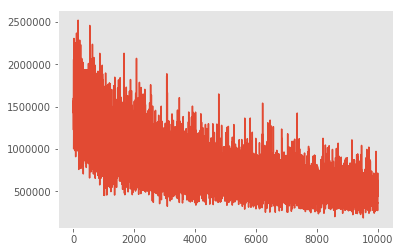

In [42]:
with model:
    advi = pm.ADVI()
    %time advi.fit(10000, more_replacements={X_shared: X_minibatch},obj_optimizer=pm.adagrad(learning_rate=1e-2))
plt.plot(advi.hist);

## Criticism
### 1. Segmentation results

In [43]:
%%time
# posterior inference
M = 300
mu_2_sample, sigmasq_2_sample, pi_2_sample = qmu_2.sample(M), qsigma_2.sample(M), qpi_2.sample(M)
x_2_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_2_sample, scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_2_sample))
x_2_broadcasted = tf.cast(tf.tile(tf.reshape(X, [N, 1, 1, D]), [1, M, K, 1]), dtype=tf.float32)
log_liks_2 = tf.reduce_mean(tf.reduce_sum(x_2_post.log_prob(x_2_broadcasted), 3), 1)
clusters_2 = tf.argmax(log_liks_2, 1).eval()
posterior_mu_2 = qmu_2.params.eval().mean(axis=0)

CPU times: user 7min 47s, sys: 2min 56s, total: 10min 43s
Wall time: 4min 56s


In [44]:
img_mcmc_2 = get_segment_img(clusters_2, img, posterior_mu_2, mcmc=True)

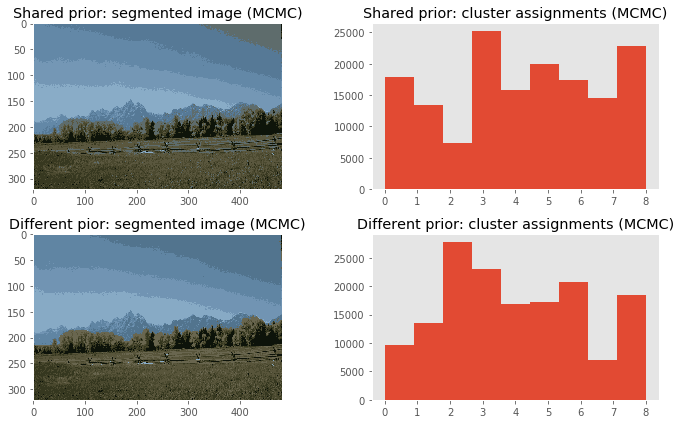

In [45]:
fig, axs = plt.subplots(2,2, figsize=(10,6))
axs[0][0].imshow(img_mcmc)
axs[0][0].set_title("Shared prior: segmented image (MCMC)")
axs[0][1].hist(clusters, bins=K);
axs[0][1].set_title("Shared prior: cluster assignments (MCMC)")
axs[1][0].imshow(img_mcmc_2)
axs[1][0].set_title("Different pior: segmented image (MCMC)")
axs[1][1].hist(clusters_2, bins=K);
axs[1][1].set_title("Different prior: cluster assignments (MCMC)")
plt.tight_layout()

MCMC's segmentation result does not vary much by switching shared prior to different prior. That is, MCMC is robust to the prior setting.

In [46]:
y_2, point_2 = predict_cluster(advi.approx, 1000, X, model, K, cov="cov_diagonal")
img_advi_2 = get_segment_img(y_2, img, point_2)

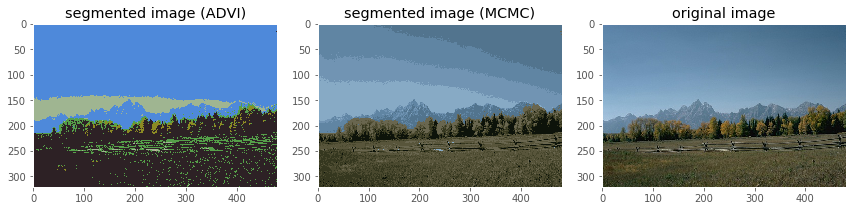

In [47]:
plt.rcParams["axes.grid"] = False
fig, axs = plt.subplots(1,3, figsize=(12,12))
axs[0].imshow(img_advi_2)
axs[0].set_title("segmented image (ADVI)")
axs[1].imshow(img_mcmc_2)
axs[1].set_title("segmented image (MCMC)")
axs[2].imshow(img)
axs[2].set_title("original image")
plt.tight_layout()

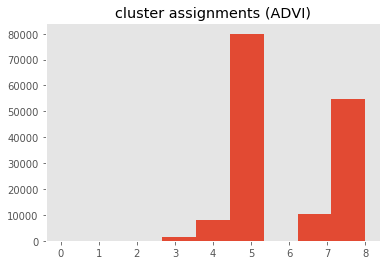

In [48]:
plt.hist(y_2, bins=K);
plt.title("cluster assignments (ADVI)");

For ADVI, the segmented image seems much better than the previous one, with 5 clusters identified. Hence the different-prior setting does help.

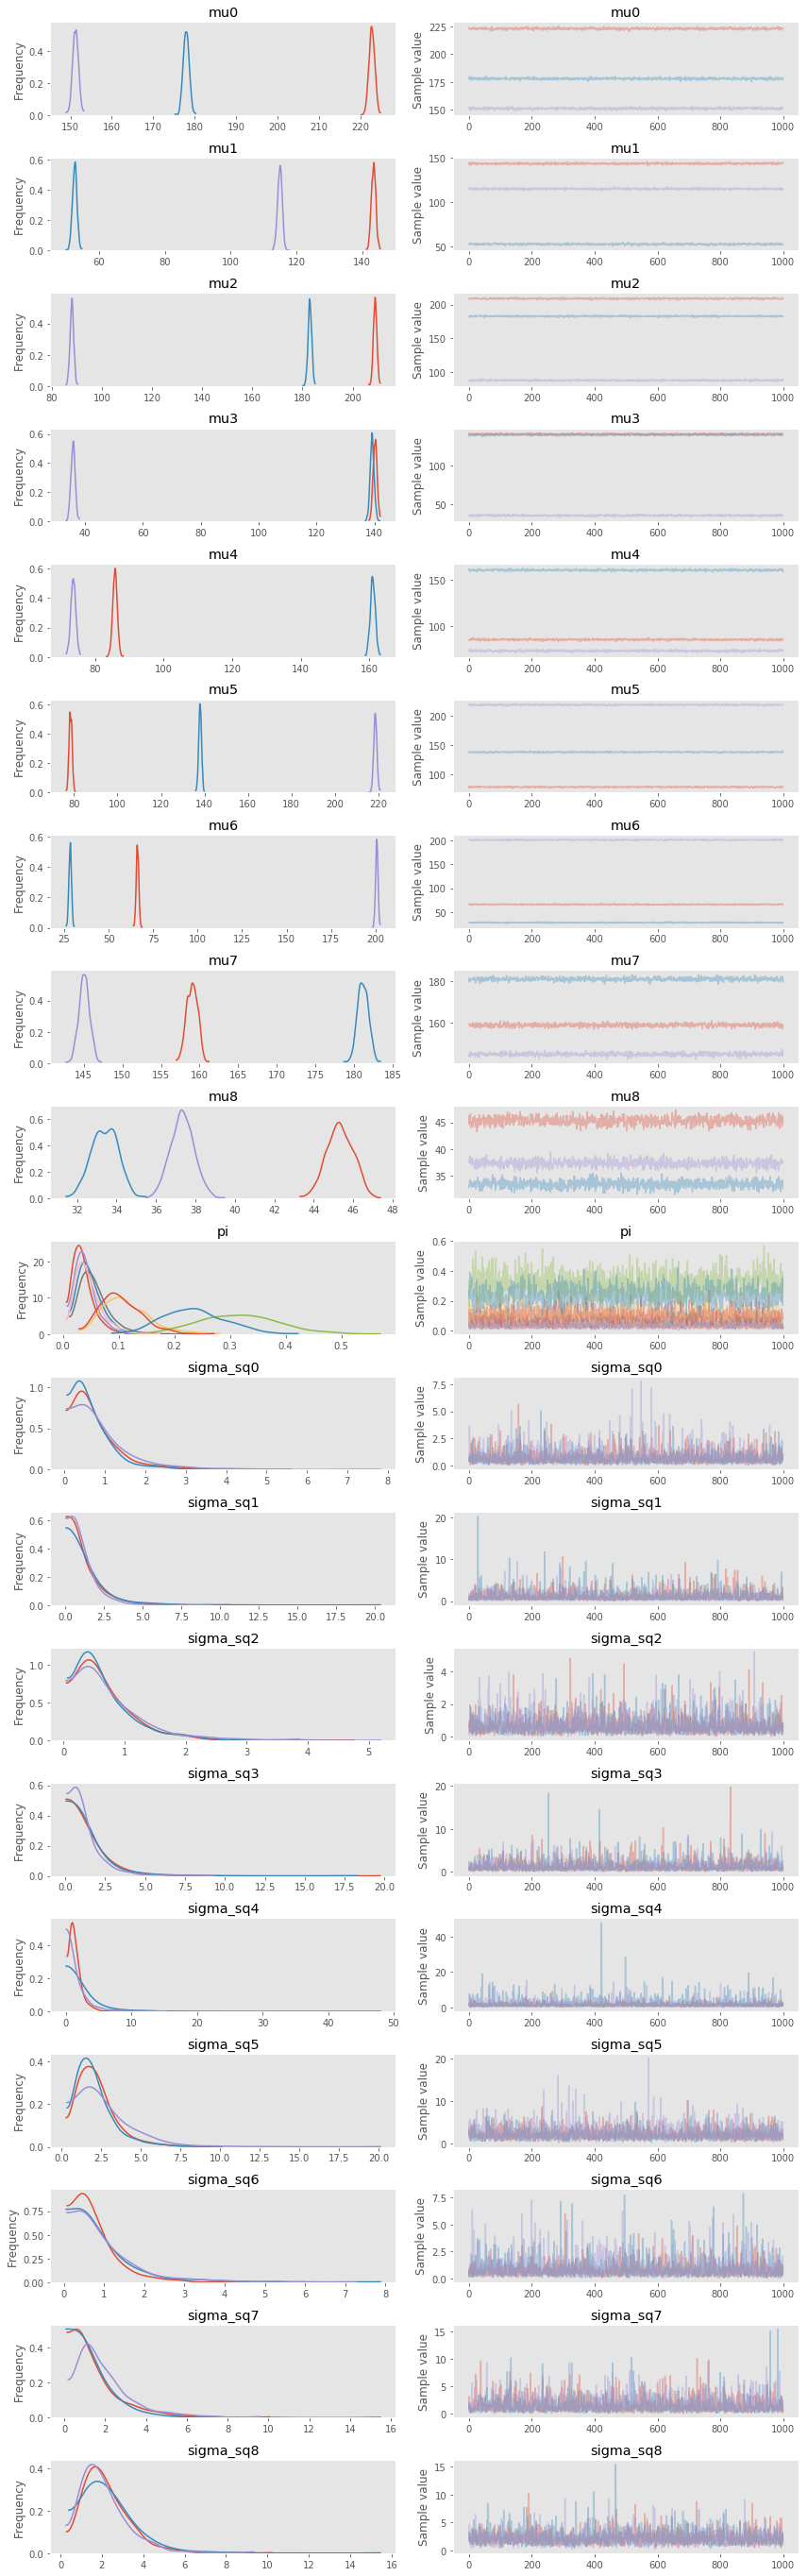

In [49]:
post_samples_2 = advi.approx.sample(1000)
pm.traceplot(post_samples_2);

Checking the posterior, each $\mu_k$ subjects to different distribution. It also reflects a different prior setting for $\mu_k$ helps.


However, the number of clusters identified by ADVI is less than that of MCMC. Moreover, the color of MCMC's result is closer to the truth which indicates a more accurate posterior distribution for $\mu_k$.

#### How to get a better ADVI segmentation?

- Increase the number of clusters $K$.
- Fine tune the prior.

### 2. Clustering metric

In this section, we will compare the inference (MCMC/ADVI) segmentation with the hand-labeled segmentation -- referred as the "ground-truth".

First, let's look at the ground-truth.

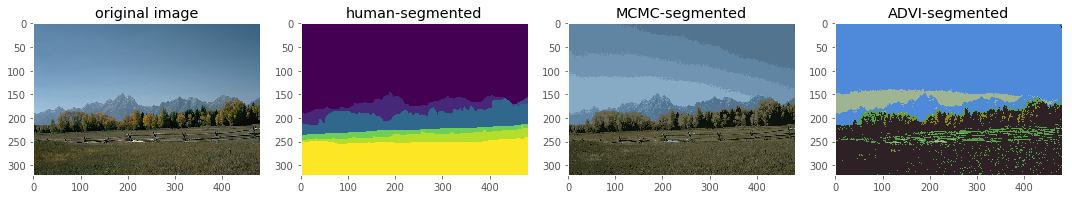

In [87]:
# importing ground truth
from scipy.io import loadmat
truth_path = "../BSR/BSDS500/data/groundTruth/train/"
gt = loadmat(truth_path + "{0:d}.mat".format(img_no)) 
gt_seg = gt['groundTruth'][0][1][0,0][0].astype('int64')
plot_seg_vs_truth(img, gt_seg, img_mcmc_2, img_advi_2)

We use some common metrics to compare the agreement of inference segmentation to the ground-truth.

In [53]:
print("MCMC:")
cluster_metric(gt_seg.flatten(), clusters_2)
print("\nADVI:")
cluster_metric(gt_seg.flatten(), y_2)

MCMC:
Homogeneity: 0.555
Completeness: 0.355
V-measure: 0.433
Adjusted Rand Index: 0.244
Adjusted Mutual Information: 0.355

ADVI:
Homogeneity: 0.500
Completeness: 0.627
V-measure: 0.556
Adjusted Rand Index: 0.580
Adjusted Mutual Information: 0.500


__MCMC only outperforms ADVI in the Homogeneity score.__

#### Why?

This is because that MCMC gives a much finer result than the human segmentation. That is, MCMC __"over-segments"__ the image while ignoring the semantic meaning.

#### How to imrove MCMC in terms of clustering metrics?

- Reduce the number of clusters $K$ to avoid over-segmentation.


### 3. PDI

Let
$$\mu (n) = \mathbb{E}_{\theta | x} [p(x_n | \theta) ], \qquad \mu_{\log} (n) = \mathbb{E}_{\theta | x} [\log p(x_n | \theta)], \qquad \sigma^2 (n) = \mathbb{V}_{\theta | x} [p(x_n | \theta)], \qquad \sigma^2_{\theta | x} [\log p(x_n | \theta)] . $$

A PDI is a ratio of variance to expectation. Intuitively, the variance highlights potential model mismatch; dividing them by the mean calibrates this spread to its predictive accuracy.

In thie notebook we consider following indices:
$$\text{PDI}(n) = \frac{\sigma^2 (n)}{\mu (n)}  \qquad \text{PDI-log}(n) = \frac{\sigma^2_{\log} (n)}{\mu_{\log} (n)} \qquad 
\text{WAPDI}(n) = \frac{\sigma^2_{\log}(n)}{\log \mu (n)}$$

and we also compute: 
$$\text{log-PDI}(n) = \log (\text{PDI} (n))$$
since we find the distribution of PDI($n$) is quite spiky.

Reference: [PDI2016](https://arxiv.org/pdf/1605.07604.pdf)

In [57]:
%%time
# MCMC
log_liks_3 = tf.reduce_sum(x_2_post.log_prob(x_2_broadcasted), 3)
pi_samples_tiled_3 = tf.tile(tf.expand_dims(tf.log(pi_2_sample), 0), [N, 1, 1])
sum_log_pi_normal_3 = tf.add(pi_samples_tiled_3, log_liks_3)
x_max_3 = tf.reduce_max(sum_log_pi_normal_3, axis=2)
edited_log_sum_3 = tf.add(x_max_3, tf.log(tf.reduce_sum(tf.exp(sum_log_pi_normal_3 -tf.expand_dims(x_max_3, 2)), axis=2)))
pdi_mean, pdi_variance = tf.nn.moments(tf.exp(edited_log_sum_3), axes=[1])
pdi = tf.divide(pdi_variance, pdi_mean)
wapdi_mean, wapdi_variance = tf.nn.moments(edited_log_sum_3, axes=[1])
wapdi_log_mean = tf.log(pdi_mean)
wapdi = tf.divide(wapdi_variance, wapdi_log_mean)
pdi_log = tf.divide(wapdi_variance, wapdi_mean)
pdi_mcmc, pdi_log_mcmc, wapdi_mcmc = sess.run([pdi, pdi_log, wapdi])

CPU times: user 8min 14s, sys: 2min 59s, total: 11min 14s
Wall time: 4min 54s


In [60]:
log_pdi_mcmc = np.log(pdi_mcmc)

In [58]:
# ADVI
pdi_advi, pdi_log_advi, wapdi_advi = PDI(post_samples, model)
log_pdi_advi = np.log(pdi_advi)

### 1). Visualize and compare

#### a. Density distribution

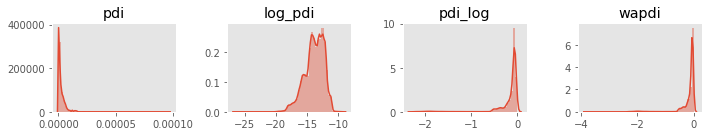

In [61]:
# MCMC
plot_pdi_wapdi(pdi_mcmc, log_pdi_mcmc, pdi_log_mcmc, wapdi_mcmc, plot_type="dist")

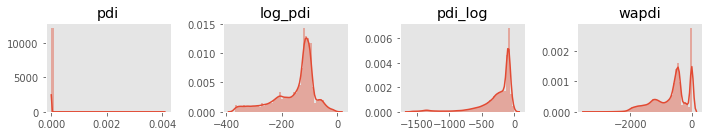

In [62]:
# ADVI
plot_pdi_wapdi(pdi_advi, log_pdi_advi, pdi_log_advi, wapdi_advi, img=img, plot_type="dist")

From the plots above, we can find that, 
- For the same index, the density distributions inferred by MCMC and ADVI are similar, since they are all approximations to the distribution inferred by the true posteior.
- The distributions of the last three indices are all left-skewed.
-  __If we believe that most of data points are matched well, and only a few are outliers, then a left-skewed distribution indicates that data points with high index value, match the model well, while small index value indicates outliers.__

Note: the scale of index value differs from MCMC to ADVI. This is because the implementation of log-likelihood is up to a constant to the true one.

#### b. Heatmap

We use the heatmap to visualize the index values. We expect low-heat, darker-colored pixels appear in the margin between different segments.

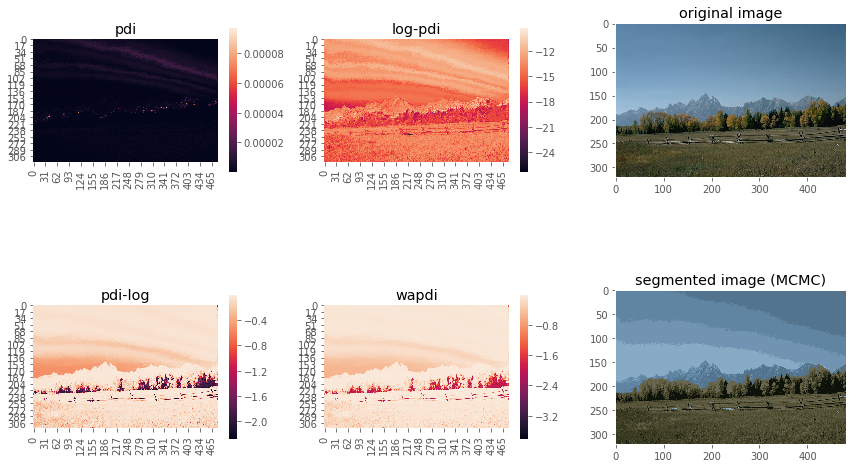

In [63]:
plot_pdi_wapdi(pdi_mcmc, log_pdi_mcmc, pdi_log_mcmc, wapdi_mcmc, img, img_mcmc_2, name="MCMC", k=0.5, plot_type="heatmap")

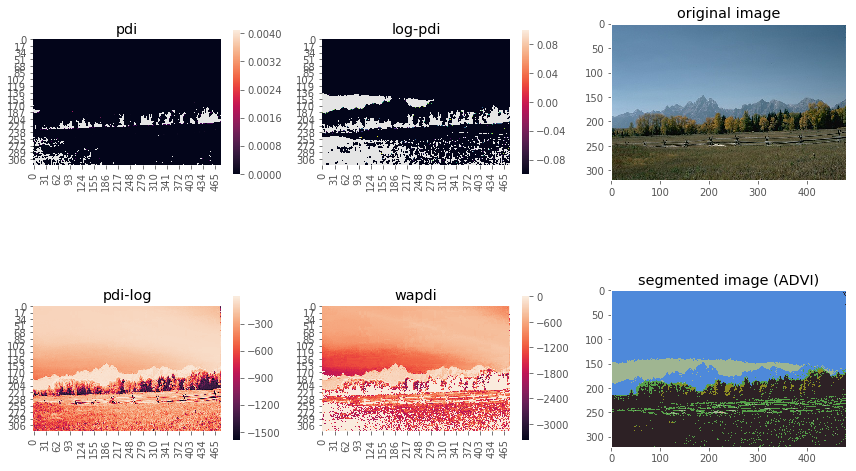

In [64]:
plot_pdi_wapdi(pdi_advi, log_pdi_advi, pdi_log_advi, wapdi_advi, img, img_advi_2, name="ADVI", k=0.5, plot_type="heatmap")

Observations:

- In both the MCMC and ADVI inferred results, the heatmaps "reveal" the segmentation.
- __Darker-colored pixels tend to appear near the margins between segments.__

### 2). More examples

We need to run experiments on more image to validate our intuition.

Setting: for computation consideration, we use ADVI. For all experiments, we use the reset model with $K=20$.

#### a. Density distribution
- PDI density distributions are all spiky, hence we turn to log-PDI. 
- For the negative-valued index (log-PDI, PDI-log and WAPDI), the density distributions are mostly left-skewed.

#### b. Heatmap

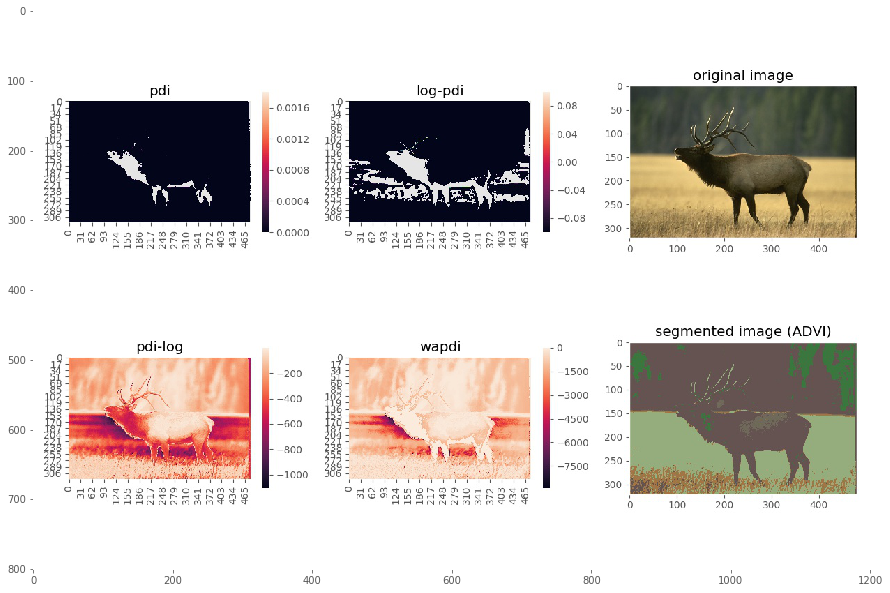

In [83]:
test_path = "../out/ADVI_invgamma/"
img_41004 = plt.imread(test_path + "41004_1/pdi_heat.jpg")
plt.figure(figsize = (15,15))
plt.imshow(img_41004);

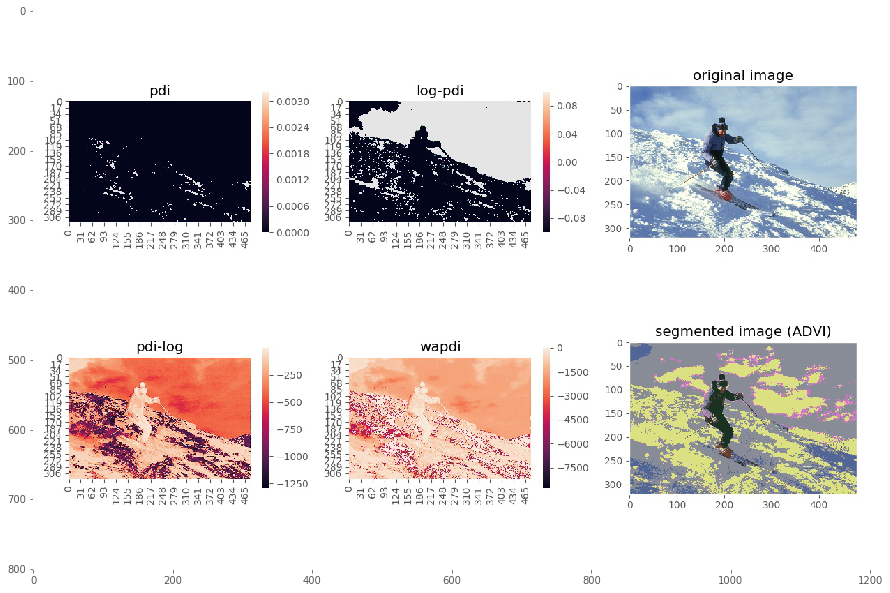

In [85]:
img_61060 = plt.imread(test_path + "61060_1/pdi_heat.jpg")
plt.figure(figsize = (15,15))
plt.imshow(img_61060);

The observations are consistent with the example above:
- The heatmaps "reveal" the segmentation, expecially pdi-log and wapdi, while the distributions of pdi and log-pdi are very spiky thereby leading to a black-and-white heatmap.
- In the heatmaps of pdi-log and wapdi, darker-colored pixels tend to outline the margin of segments, or appear in the regions divided into many small segments.

## Conclusions

- Prior setting
    - MCMC is robust to prior setting, while ADVI is sensitive.
    - A different-prior setting helps ADVI's segmentation performance.

- Segmentation results
    - Using the same cluster number $K=9$, MCMC identify all 9 clusters while ADVI collapses to 5.
    - In infering posterior cluster centers $\mu_k$, MCMC is better than ADVI.
    - However, due to the large $K$ setting, MCMC over-segments the image compared to the ground-truth.

- Computation time
    - ADVI runs much faster than MCMC.

- PDI
    - Identifies "outliers" -- pixels in the margin between segments.

## References

[[Box's Loop](https://www.jstor.org/stable/2286841?seq=1#metadata_info_tab_contents)] George E. P. Box, Science and statistics, Journal of the American Statistical Association

[[BSDS](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/)] Berkeley Segmentation Dataset and Benchmark

[[advi2016](https://arxiv.org/pdf/1603.00788.pdf)] Alp Kucukelbir, Dustin Tran, Rajesh Ranganath, Andrew Gelman, David M. Blei,  	arXiv:1603.00788 [stat.ML]

[[PDI2016](https://arxiv.org/pdf/1605.07604.pdf)] Alp Kucukelbir, David M. Blei, arXiv:1605.07604 [stat.ML]